# Analyzing 'The Class' Network
In this exercise I will look at the graph of our class and its properties.  
It’s rarely enough to notice that two people are connected with one another. Factors such as their structural relation to further people and whether those additional people are themselves connected to one another have decisive influence on events.  
I will look at the overall structure of the network, who are the important people (hubs) in the network and what are the subgroups in the network.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
import seaborn as sns

### Import and look at the data

In [2]:
df = pd.read_csv('theclass.csv', sep=';', header=None,
                 names=["Source", "Target", "Weight"])
df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
Source,damaso,jurjen,damaso,jurjen,diego,fernando,diego,jurjen,mario,mario,...,estefania,estefania,pablo,pablo,pablo,pablo,pablo,alicia,alicia,alicia
Target,mario,alberto,raul,juango,mario,alberto,damaso,mario,damaso,diego,...,mario,damaso,sara,alicia,pedro,mario,xana,pedro,pablo,lorena
Weight,3,2,2,1,2,3,1,3,2,2,...,1,1,3,3,2,2,2,2,2,1


Here the *weight* is the importance of a connection.

### Clean data

In [3]:
# juango is the same person as juanjo
# guillermo is the same person as guille
df.replace("juango", "juanjo", inplace=True)
df.replace("guillermo", "guille", inplace=True)
# edge 'juanjo;sara' exists twice => removing row 48
# las vegas is not a person => removing row 51
df.drop([48, 51], axis=0, inplace=True)

### Define and inspect graph
For most of this exercise I will use a directed graph.

In [4]:
G=nx.from_pandas_dataframe(df, 'Source', 'Target', edge_attr=True, create_using=nx.DiGraph())
G.name = "The Class"

In [5]:
print(nx.info(G))

Name: The Class
Type: DiGraph
Number of nodes: 21
Number of edges: 63
Average in degree:   3.0000
Average out degree:   3.0000


In [6]:
G.edges(data=True)[0:10]

[('damaso', 'mario', {'Weight': 3}),
 ('damaso', 'raul', {'Weight': 2}),
 ('mario', 'damaso', {'Weight': 2}),
 ('mario', 'diego', {'Weight': 2}),
 ('mario', 'sara', {'Weight': 3}),
 ('mario', 'guille', {'Weight': 3}),
 ('mario', 'juanjo', {'Weight': 1}),
 ('jurjen', 'alberto', {'Weight': 2}),
 ('jurjen', 'juanjo', {'Weight': 1}),
 ('jurjen', 'mario', {'Weight': 3})]

In [7]:
names = G.nodes()
print(names)

['damaso', 'mario', 'jurjen', 'alberto', 'raul', 'juanjo', 'diego', 'fernando', 'sara', 'guille', 'xana', 'estefania', 'pablo', 'fede', 'sole', 'rafa', 'alicia', 'edu', 'dani', 'pedro', 'lorena']


### Adding gender

In [8]:
# I will add the gender as a node property
names_women = ['sara', 'xana', 'estefania', 'sole', 'alicia', 'lorena']
names_men = np.setdiff1d(names, names_women)
for woman in names_women:
    G.node[woman] = {'gender': 'female'}
for man in names_men:
    G.node[man] = {'gender': 'male'}

In [9]:
node_properties = pd.DataFrame([i[1] for i in G.nodes(data=True)], index=[i[0] for i in G.nodes(data=True)])
node_properties.transpose()

,damaso,mario,jurjen,alberto,raul,juanjo,diego,fernando,sara,guille,...,estefania,pablo,fede,sole,rafa,alicia,edu,dani,pedro,lorena
gender,male,male,male,male,male,male,male,male,female,male,...,female,male,male,female,male,female,male,male,male,female


In [10]:
# I will use the gender property to color the nodes of the graph
node_color = [word.replace('female','magenta') for word in node_properties['gender']]
node_color = [word.replace('male','deepskyblue') for word in node_color]

## The shape of the network
For the first plot I will use a circular layout.

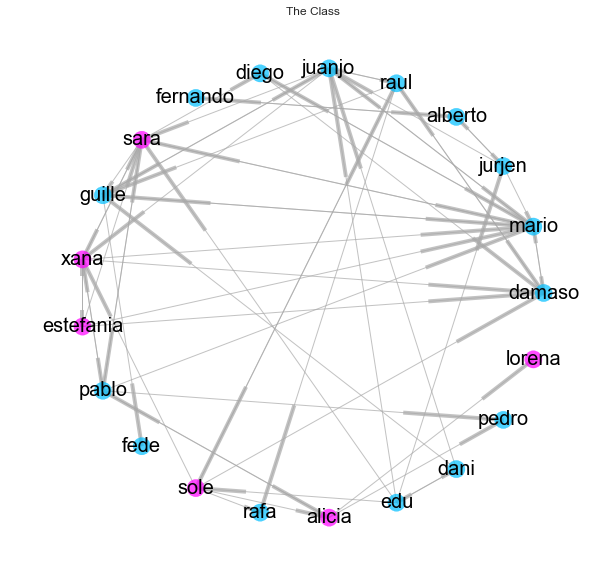

In [11]:
plt.figure(figsize=(10, 10))
limits=plt.axis('off')
nx.draw_networkx(G, pos=nx.circular_layout(G),
                 node_color=node_color, edge_color='darkgray', alpha=0.7, font_size=20)
plt.title(G.name)
plt.savefig("TheClass_CircularGraph.png", dpi=150)
plt.show()

### Density

In [12]:
density = nx.density(G)
print("Network density:", density)

Network density: 0.15


Our network isn't very dense. Let's look at the connections in a matrix:

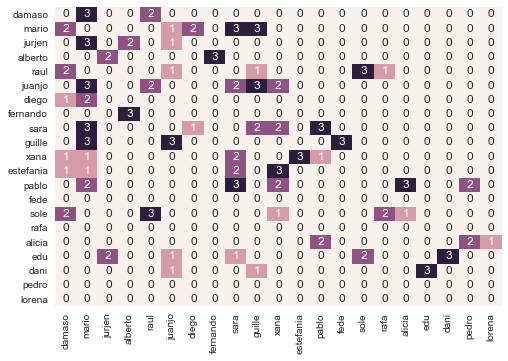

In [13]:
M = nx.adjacency_matrix(G, nodelist=G.nodes(), weight='Weight').todense()
sns.heatmap(M, xticklabels=G.nodes(), yticklabels=G.nodes(), annot=True, cbar=False)
plt.savefig("Connections_Matrix.png", dpi=150)
plt.show()

### Triadic closure
Triadic closure supposes that if two people know the same person, they are likely to know each other.  
One way of measuring triadic closure is transitivity. Transitivity is the ratio of all triangles over all possible triangles.

In [14]:
triadic_closure = nx.transitivity(G)
print("Triadic closure:", round(triadic_closure, 2))

Triadic closure: 0.34


### Degree
The degree represents the number of connections a person has. I will use the weights in the calculation of the degree of the nodes.

In [15]:
degree = G.degree(G.nodes(), weight='Weight')
nx.set_node_attributes(G, 'degree', degree)
degree_sorted = sorted(degree, key=degree.__getitem__, reverse=True)
print('\033[1m' + "Top 5 nodes by (weighted) degree:")
for d in degree_sorted[:5]:
    print('\033[0m' + d, degree[d])

Top 5 nodes by (weighted) degree:
mario 32
sara 24
juanjo 20
guille 19
xana 18


In [16]:
indegree = G.in_degree(G.nodes(), weight='Weight')
nx.set_node_attributes(G, 'indegree', indegree)
indegree_sorted = sorted(indegree, key=indegree.__getitem__, reverse=True)
print('\033[1m' + "Top 5 nodes by (weighted) indegree:")
for d in indegree_sorted[:5]:
    print('\033[0m' + d, indegree[d])

Top 5 nodes by (weighted) indegree:
mario 21
sara 13
guille 10
xana 10
damaso 9


In [17]:
outdegree = G.out_degree(G.nodes(), weight='Weight')
nx.set_node_attributes(G, 'outdegree', outdegree)
outdegree_sorted = sorted(outdegree, key=outdegree.__getitem__, reverse=True)
print('\033[1m' + "Top 5 nodes by (weighted) outdegree:")
for d in outdegree_sorted[:5]:
    print('\033[0m' + d, outdegree[d])

Top 5 nodes by (weighted) outdegree:
juanjo 12
pablo 12
mario 11
sara 11
guille 9


In [18]:
for d in indegree_sorted[:10]:
    print("Name:", d, "| Indegree:", indegree[d], "| Outdegree:", outdegree[d], "| Degree:", degree[d])

Name: mario | Indegree: 21 | Outdegree: 11 | Degree: 32
Name: sara | Indegree: 13 | Outdegree: 11 | Degree: 24
Name: guille | Indegree: 10 | Outdegree: 9 | Degree: 19
Name: xana | Indegree: 10 | Outdegree: 8 | Degree: 18
Name: damaso | Indegree: 9 | Outdegree: 5 | Degree: 14
Name: juanjo | Indegree: 8 | Outdegree: 12 | Degree: 20
Name: raul | Indegree: 7 | Outdegree: 8 | Degree: 15
Name: pablo | Indegree: 6 | Outdegree: 12 | Degree: 18
Name: alberto | Indegree: 5 | Outdegree: 5 | Degree: 10
Name: sole | Indegree: 5 | Outdegree: 9 | Degree: 14


When ties between people are associated to some positive aspects such as friendship or collaboration, indegree is often interpreted as a form of popularity, and outdegree as gregariousness.  
We see that in this example Mario can be considered to be the most popular. He is valued for friendship or collabaroration more than he values the friendship or collaboration of other people. Of course this is a very dangerous conclusion, because everybody put their own weight and the interpretation of the weight values is very subjective.

In [19]:
# I will use degree for the nodesize in the graph below
node_size = np.array(list(degree.values())) * 1000/max(degree.values())

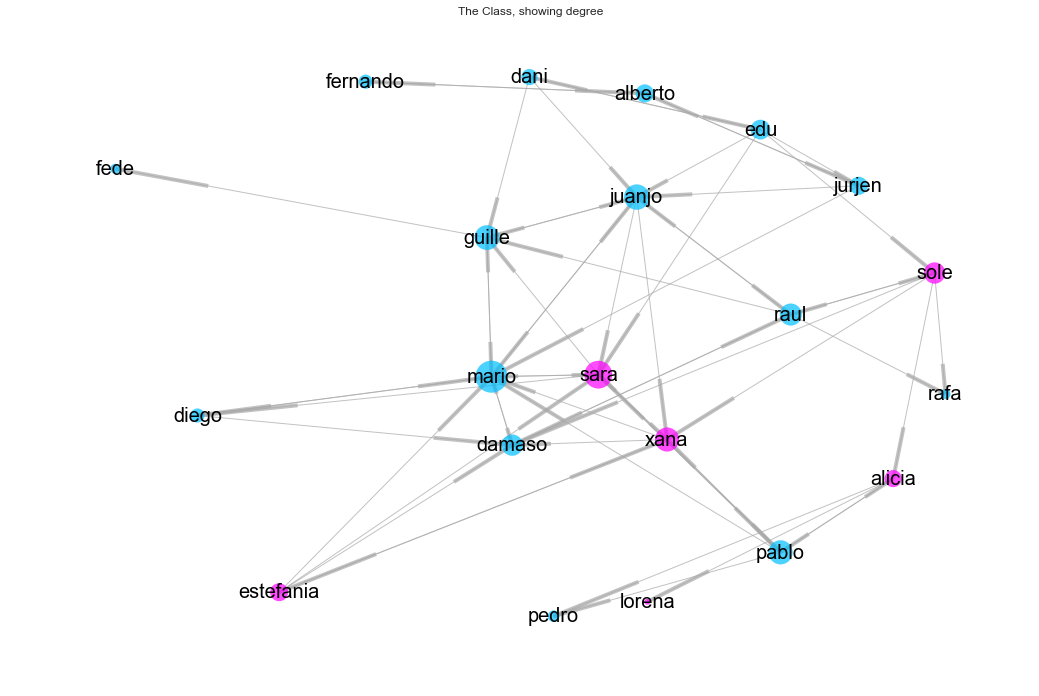

In [20]:
pos=nx.spring_layout(G,iterations=100)

plt.figure(figsize=(18, 12))
limits=plt.axis('off')
nx.draw_networkx(G, pos=pos,
                 node_size=node_size, node_color=node_color, edge_color='darkgray', alpha=0.7, font_size=20)
plt.title("The Class, showing degree")
plt.savefig("TheClass_SpringLayout.png", dpi=150)
plt.show()

## Centrality
In graph theory and network analysis, indicators of centrality identify 'the most important' nodes (vertices) within a graph.  
The word *importance* has a wide number of meanings, leading to many different definitions of centrality. Two categorization schemes have been proposed:  
* Importance can be conceived in relation to a type of flow or transfer across the network. This allows centralities to be classified by the type of flow they consider important.
* Importance can alternatively be conceived as involvement in the cohesiveness of the network. This allows centralities to be classified based on how they measure cohesiveness. 

Both of these approaches divide centralities in distinct categories. A further conclusion is that a centrality which is appropriate for one category will often "get it wrong" when applied to a different category.

### Pagerank centrality
Any data which can be modeled as a directional graph can be analyzed with PageRank.

In [21]:
pagerank = nx.pagerank(G, weight='Weight')
nx.set_node_attributes(G, 'pagerank', pagerank)
pagerank_sorted = sorted(pagerank, key=pagerank.__getitem__, reverse=True)
print('\033[1m' + "Top 10 nodes by pagerank:")
for d in pagerank_sorted[:10]:
    print('\033[0m' + "Name:", d, "| Pagerank:", round(pagerank[d],2), "| Degree:", degree[d])

Top 10 nodes by pagerank:
Name: mario | Pagerank: 0.16 | Degree: 32
Name: sara | Pagerank: 0.09 | Degree: 24
Name: guille | Pagerank: 0.08 | Degree: 19
Name: damaso | Pagerank: 0.07 | Degree: 14
Name: juanjo | Pagerank: 0.06 | Degree: 20
Name: raul | Pagerank: 0.05 | Degree: 15
Name: xana | Pagerank: 0.05 | Degree: 18
Name: alberto | Pagerank: 0.05 | Degree: 10
Name: pablo | Pagerank: 0.04 | Degree: 18
Name: diego | Pagerank: 0.04 | Degree: 6


We see that pagerank gives a ranking that gives the same "top3" as ranking by weighted degree.

### Betweenness centrality

In [22]:
betweenness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, 'betweenness', betweenness)
betweenness_sorted = sorted(betweenness, key=betweenness.__getitem__, reverse=True)
for tb in betweenness_sorted[:5]:
    print("Name:", tb, "| Betweenness Centrality:", betweenness[tb], "| Pagerank:", pagerank[tb])

Name: juanjo | Betweenness Centrality: 0.1481578947368421 | Pagerank: 0.06201416187193948
Name: mario | Betweenness Centrality: 0.13907894736842102 | Pagerank: 0.158884718709925
Name: pablo | Betweenness Centrality: 0.10548245614035086 | Pagerank: 0.0447239914035264
Name: raul | Betweenness Centrality: 0.1018421052631579 | Pagerank: 0.0542525408546005
Name: sara | Betweenness Centrality: 0.09780701754385963 | Pagerank: 0.08608760927439331


As can be seen betweenness gives a different ranking than pagerank.

### Eigenvector centrality

In [23]:
eigenvector = nx.eigenvector_centrality(G)
nx.set_node_attributes(G, 'eigenvector', eigenvector)
eigenvector_sorted = sorted(eigenvector, key=eigenvector.__getitem__, reverse=True)
print('\033[1m' + "Top 5 nodes by eigenvector centrality:")
for d in eigenvector_sorted[:5]:
    print('\033[0m' + d, eigenvector[d])

Top 5 nodes by eigenvector centrality:
mario 0.5576008631918341
guille 0.36852558712234257
damaso 0.35685046527644526
sara 0.3552178708866749
juanjo 0.2941815010783171


### Shortest path
I am interested in how many steps it takes someone in this class to reach somebody else through a person he/she knows.  
In this *directed* graph everybody isn't connected to everybody, *not even indirectly*. But if we convert it to an undirectional graph, the graph is connected.

In [24]:
G2 = G.to_undirected()
nx.is_connected(G2)

True

In [25]:
density_undirected = nx.density(G2)
print("Network density of undirected graph:", round(density_undirected,2))

Network density of undirected graph: 0.22


In [26]:
P = nx.shortest_path(G2, weight=None)   # weihts have no meaning here

In [27]:
print("Shortest path between Jurjen and Diego:", P['jurjen']['diego'])
print("Length of that path:", len(P['jurjen']['diego'])-1)

Shortest path between Jurjen and Diego: ['jurjen', 'mario', 'diego']
Length of that path: 2


In [28]:
print("Shortest path between Lorena and Diego:", P['lorena']['diego'])
print("Length of that path:", len(P['lorena']['diego'])-1)

Shortest path between Lorena and Diego: ['lorena', 'alicia', 'pablo', 'sara', 'diego']
Length of that path: 4


The maximum shortest distance in the graph is 6


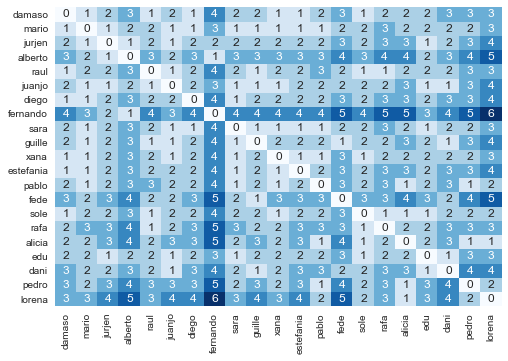

In [29]:
n = len(G.nodes())
M2 = np.zeros((n,n))
for s in range(n):
    for t in range(n):
        M2[s,t] = len(P[G.nodes()[s]][G.nodes()[t]])-1
print("The maximum shortest distance in the graph is", np.max(M2).astype(int))
# plot heatmap
sns.heatmap(M2, xticklabels=G.nodes(), yticklabels=G.nodes(), annot=True, cmap="Blues", cbar=False)
plt.savefig("ShortestDistance_Matrix.png", dpi=150)
plt.show()

In the matrix above you can see for example that it takes Fernando relatively long to reach another person of the group.  
Let's see who can reach others relatively fast and make a ranking out of this.

In [30]:
people = G.nodes()
distance = M2.mean(axis=1)
average_distance_from = dict(zip(people, distance))
nx.set_node_attributes(G, 'mean_dist', average_distance_from)
average_distance_from_sorted = sorted(average_distance_from, key=average_distance_from.__getitem__)
print('\033[1m' + "Top 5 nodes by average distance from node:")
for d in average_distance_from_sorted[:5]:
    print('\033[0m' + d, round(average_distance_from[d],2))

Top 5 nodes by average distance from node:
mario 1.62
juanjo 1.76
sara 1.76
xana 1.81
sole 1.81


In [31]:
# Let's add the maximum shortest distance for every person as a node property:
keys = G.nodes()
values = np.max(M2, axis=0).astype(int)
max_dist = dict(zip(keys, values))
nx.set_node_attributes(G, 'max_dist', max_dist)
print(max_dist)

{'damaso': 4, 'mario': 3, 'jurjen': 4, 'alberto': 5, 'raul': 4, 'juanjo': 4, 'diego': 4, 'fernando': 6, 'sara': 4, 'guille': 4, 'xana': 4, 'estefania': 4, 'pablo': 4, 'fede': 5, 'sole': 4, 'rafa': 5, 'alicia': 5, 'edu': 3, 'dani': 4, 'pedro': 5, 'lorena': 6}


### Diameter
A graph's diameter is the largest number of vertices which must be traversed in order to travel from one vertex to another when paths which backtrack, detour, or loop are excluded from consideration. In the connected graph G2 the diameter is the same as the maximum shortest distance calculated above.

In [32]:
print("The diameter of the graph is", nx.diameter(G2))

The diameter of the graph is 6


### Zoom in on Jurjen

In [33]:
# How many steps does it take me to reach some else?
dist_from_jurjen = {}
for t in range(n):
    dist_from_jurjen[G.nodes()[t]] = len(P['jurjen'][G.nodes()[t]])-1
print(dist_from_jurjen)

{'damaso': 2, 'mario': 1, 'jurjen': 0, 'alberto': 1, 'raul': 2, 'juanjo': 1, 'diego': 2, 'fernando': 2, 'sara': 2, 'guille': 2, 'xana': 2, 'estefania': 2, 'pablo': 2, 'fede': 3, 'sole': 2, 'rafa': 3, 'alicia': 3, 'edu': 1, 'dani': 2, 'pedro': 3, 'lorena': 4}


In [34]:
# Through which paths are those people reached?
P['jurjen']

{'alberto': ['jurjen', 'alberto'],
 'alicia': ['jurjen', 'mario', 'pablo', 'alicia'],
 'damaso': ['jurjen', 'mario', 'damaso'],
 'dani': ['jurjen', 'juanjo', 'dani'],
 'diego': ['jurjen', 'mario', 'diego'],
 'edu': ['jurjen', 'edu'],
 'estefania': ['jurjen', 'mario', 'estefania'],
 'fede': ['jurjen', 'juanjo', 'guille', 'fede'],
 'fernando': ['jurjen', 'alberto', 'fernando'],
 'guille': ['jurjen', 'juanjo', 'guille'],
 'juanjo': ['jurjen', 'juanjo'],
 'jurjen': ['jurjen'],
 'lorena': ['jurjen', 'mario', 'pablo', 'alicia', 'lorena'],
 'mario': ['jurjen', 'mario'],
 'pablo': ['jurjen', 'mario', 'pablo'],
 'pedro': ['jurjen', 'mario', 'pablo', 'pedro'],
 'rafa': ['jurjen', 'juanjo', 'raul', 'rafa'],
 'raul': ['jurjen', 'juanjo', 'raul'],
 'sara': ['jurjen', 'juanjo', 'sara'],
 'sole': ['jurjen', 'edu', 'sole'],
 'xana': ['jurjen', 'juanjo', 'xana']}

Name: shortest_paths_from_Jurjen
Type: DiGraph
Number of nodes: 21
Number of edges: 20
Average in degree:   0.9524
Average out degree:   0.9524


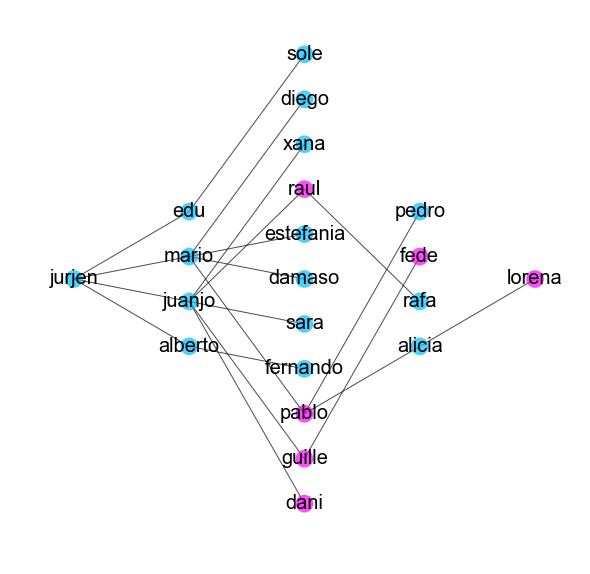

In [35]:
# defining nodes
first_degree_nodes = []
second_degree_nodes = []
third_degree_nodes = []
fourth_degree_nodes = []
for name in names:
    connections = P['jurjen'][name]
    if len(connections) >= 2:
        first_degree_nodes.append(connections[1])
    if len(connections) >= 3:
        second_degree_nodes.append(connections[2])
    if len(connections) >= 4:
        third_degree_nodes.append(connections[3])
    if len(connections) == 5:
        fourth_degree_nodes.append(connections[4])
first_degree_nodes = list(set(first_degree_nodes))
second_degree_nodes = list(set(second_degree_nodes))
third_degree_nodes = list(set(third_degree_nodes))
fourth_degree_nodes = list(set(fourth_degree_nodes))

# defining a position dictionary
pos2 = {'jurjen': (0,5)}
for j in range(len(first_degree_nodes)):
    pos2[first_degree_nodes[j]] = (1,j+3.5)
for j in range(len(second_degree_nodes)):
    pos2[second_degree_nodes[j]] = (2,j)
for j in range(len(third_degree_nodes)):
    pos2[third_degree_nodes[j]] = (3,j+3.5)
for j in range(len(fourth_degree_nodes)):
    pos2[fourth_degree_nodes[j]] = (4,5)

# defining edges
first_degree_paths = []
second_degree_paths = []
third_degree_paths = []
fourth_degree_paths = []
for name in names:
    connections = P['jurjen'][name]
    if len(connections) >= 2:
        first_degree_paths.append(('jurjen',connections[1]))
    if len(connections) >= 3:
        second_degree_paths.append((connections[1],connections[2]))
    if len(connections) >= 4:
        third_degree_paths.append((connections[2],connections[3]))
    if len(connections) == 5:
        fourth_degree_paths.append((connections[3],connections[4]))
first_degree_paths = list(set(first_degree_paths))
second_degree_paths = list(set(second_degree_paths))
third_degree_paths = list(set(third_degree_paths))
fourth_degree_paths = list(set(fourth_degree_paths))

# defining new graph
H=nx.DiGraph()
H.name = "shortest_paths_from_Jurjen"
H.add_node('jurjen')
H.add_edges_from(first_degree_paths)
H.add_edges_from(second_degree_paths)
H.add_edges_from(third_degree_paths)
H.add_edges_from(fourth_degree_paths)
print(nx.info(H))

# drawing new graph
plt.figure(figsize=(10, 10))
limits=plt.axis('off')
nx.draw_networkx(H, pos=pos2, node_color=node_color, edge_color='black', alpha=0.7, font_size=20, arrows=False)
plt.savefig("DistanceFromJurjen_TreeGraph.png", dpi=150)
plt.show()

### Community detection
There are many ways of calculating communities, cliques, and clusters in a network, but the most popular method currently is modularity. Modularity is a measure of relative density in a network: a community (called a module or modularity class) has high density relative to other nodes within its module but low density with those outside. Here I use the Louvain Method of community detection.

In [36]:
communities = community.best_partition(G2)
nx.set_node_attributes(G, "community_no", communities)

global_modularity = community.modularity(communities, G2)
print("The global modularity in the graph is", global_modularity)

print("")
print("Community numbers:", communities)

The global modularity in the graph is 0.3253780718336484

Community numbers: {'damaso': 0, 'mario': 0, 'jurjen': 1, 'alberto': 1, 'raul': 2, 'juanjo': 1, 'diego': 0, 'fernando': 1, 'sara': 0, 'guille': 1, 'xana': 0, 'estefania': 0, 'pablo': 3, 'fede': 1, 'sole': 2, 'rafa': 2, 'alicia': 3, 'edu': 1, 'dani': 1, 'pedro': 3, 'lorena': 3}


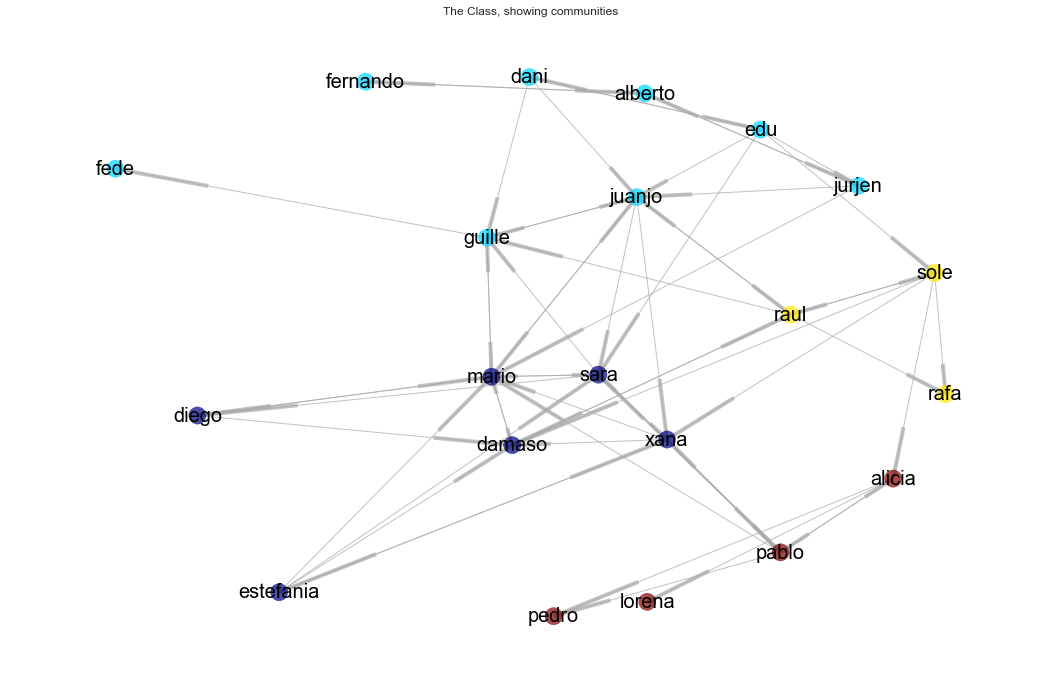

In [37]:
community_numbers = [communities.get(node) for node in G.nodes()]

plt.figure(figsize=(18, 12))
limits=plt.axis('off')
nx.draw_networkx(G, pos=pos, node_color=community_numbers, cmap = plt.get_cmap('jet'),
                 node_size=300, edge_color='darkgray', alpha=0.7, font_size=20)
plt.title("The Class, showing communities")
plt.savefig("Communities_Graph.png", dpi=150)
plt.show()

## Summary of calculated metrics

In [38]:
node_properties = pd.DataFrame([i[1] for i in G.nodes(data=True)], index=[i[0] for i in G.nodes(data=True)])
cols = ['gender', 'degree', 'indegree', 'outdegree', 'pagerank', 'betweenness', 'eigenvector', 'mean_dist', 'max_dist',
       'community_no']
summary = node_properties[cols].sort_index()
summary

,gender,degree,indegree,outdegree,pagerank,betweenness,eigenvector,mean_dist,max_dist,community_no
alberto,male,10,5,5,0.052689,0.052632,8.354320e-09,2.809524,5,1
alicia,female,9,4,5,0.023656,0.052632,5.946467e-02,2.333333,5,3
damaso,male,14,9,5,0.074259,0.049254,3.568505e-01,1.952381,4,0
dani,male,8,3,5,0.016680,0.001754,8.166490e-12,2.380952,4,1
diego,male,6,3,3,0.042326,0.002456,2.416118e-01,2.238095,4,0
edu,male,12,3,9,0.019626,0.021798,8.166490e-12,1.857143,3,1
estefania,female,10,3,7,0.027934,0.000000,6.584945e-02,2.190476,4,0
fede,male,3,3,0,0.034645,0.000000,9.754450e-02,2.857143,5,1
fernando,male,6,3,3,0.037989,0.000000,6.263698e-09,3.714286,6,1
guille,male,19,10,9,0.083033,0.049035,3.685256e-01,1.952381,4,1


### Write output

In [39]:
nx.write_gpickle(G, "G.gpickle")
summary.to_pickle("Summary.pickle")
summary.to_csv("Summary.csv")